# Imports

In [26]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

import pickle
import joblib

import warnings
warnings.filterwarnings('ignore')

# 1. Training Dataframe

In [2]:
# Load both training and test dataframes

diamonds = pd.read_csv('../data/diamonds_train.csv')
diamonds_test = pd.read_csv('../data/diamonds_test.csv')

# Drop 'index_id' and 'id' columns

diamonds.drop(['index_id'],axis=1, inplace=True)
diamonds_test.drop(['id'],axis=1, inplace=True)

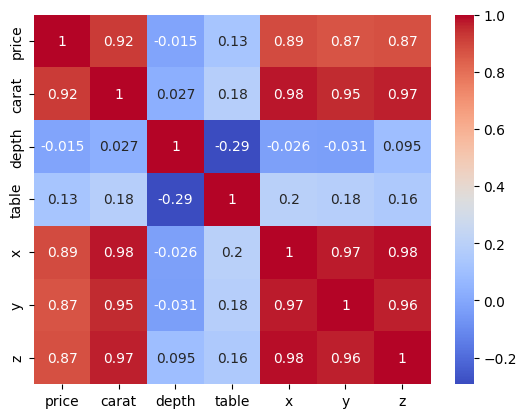

In [3]:
# Correlation Matrix

corr = diamonds.corr(numeric_only=True)
sns.heatmap(corr, cmap='coolwarm', annot=True)
plt.show()

#### 1.1. Feature Engineering

In [4]:
# Create variable 'x/y ratio'

diamonds['x/y ratio'] = diamonds['x'] / diamonds['y']
diamonds['x/y ratio'] = diamonds['x/y ratio'].fillna(0)

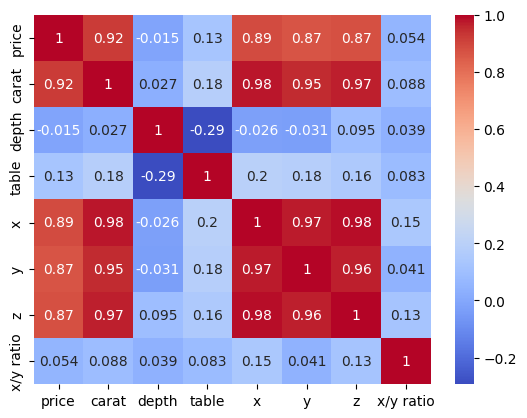

In [5]:
# Correlation Matrix

corr = diamonds.corr(numeric_only=True)
sns.heatmap(corr, cmap='coolwarm', annot=True)
plt.show()

####  1.2. Use test features for training

In [6]:
# Append both dataframes to include test data for the training

# Create identifier for both dataframes

diamonds['file'] = 'train'
diamonds_test['file'] = 'test'

# Append 'train' and 'test' dataframes

diamonds = diamonds.append(diamonds_test, ignore_index=True)

# Create variable 'x/y ratio'

diamonds['x/y ratio'] = diamonds['x'] / diamonds['y']
diamonds['x/y ratio'] = diamonds['x/y ratio'].fillna(0)
diamonds

,price,carat,city,cut,color,clarity,depth,table,x,y,z,x/y ratio,file
0,4268.0,1.21,Dubai,Premium,J,VS2,62.4,58.0,6.83,6.79,4.25,1.005891,train
1,4882.0,1.02,Dubai,Ideal,G,SI1,60.5,59.0,6.55,6.51,3.95,1.006144,train
2,14208.0,2.00,Dubai,Premium,I,SI2,61.3,59.0,8.13,8.09,4.97,1.004944,train
3,5113.0,1.01,Dubai,Good,G,SI1,63.7,60.0,6.32,6.28,4.01,1.006369,train
4,2898.0,0.79,Dubai,Ideal,G,SI1,62.3,57.0,5.90,5.85,3.66,1.008547,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...
53935,NaN,0.57,Amsterdam,Ideal,E,SI1,61.9,56.0,5.35,5.32,3.30,1.005639,test
53936,NaN,0.71,New York City,Ideal,I,VS2,62.2,55.0,5.71,5.73,3.56,0.996510,test
53937,NaN,0.70,Tel Aviv,Ideal,F,VS1,61.6,55.0,5.75,5.71,3.53,1.007005,test
53938,NaN,0.70,Surat,Very Good,F,SI2,58.8,57.0,5.85,5.89,3.45,0.993209,test


####  1.3. Dropping Outliers

In [7]:
diamonds.describe()

,price,carat,depth,table,x,y,z,x/y ratio
count,40455.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,3928.444469,0.797940,61.749405,57.457184,5.731157,5.734526,3.538734,0.999279
std,3992.416147,0.474011,1.432621,2.234491,1.121761,1.142135,0.705699,0.016858
min,326.000000,0.200000,43.000000,43.000000,0.000000,0.000000,0.000000,0.000000
25%,945.000000,0.400000,61.000000,56.000000,4.710000,4.720000,2.910000,0.992625
50%,2397.000000,0.700000,61.800000,57.000000,5.700000,5.710000,3.530000,0.995745
75%,5331.000000,1.040000,62.500000,59.000000,6.540000,6.540000,4.040000,1.006944
max,18823.000000,5.010000,79.000000,95.000000,10.740000,58.900000,31.800000,1.615572


In [8]:
# Dropping zero values for x, y and z

diamonds = diamonds[(diamonds['x'] > 0) & (diamonds['y'] > 0) & (diamonds['z'] > 0)]

# Dropping outliers for y

diamonds = diamonds[diamonds['y'] < 30]
diamonds.reset_index(drop=True, inplace=True)

# Divide depth and table / 100

diamonds['table'] = diamonds['table'] / 100
diamonds['depth'] = diamonds['depth'] / 100

# Dropping outliers for z

diamonds['depth-2'] = round(2 * diamonds['z'] / (diamonds['x'] + diamonds['y']), 3)
diamonds['depth-check'] = diamonds['depth'] == diamonds['depth-2']
diamonds['depth-diff'] = round(diamonds['depth'] - diamonds['depth-2'],1)
print(diamonds[diamonds['depth-check'] == False]['depth-diff'].value_counts())
diamonds = diamonds[(diamonds['depth-diff'] < 0.4) & (diamonds['depth-diff'] > -0.4)]
diamonds.drop(['depth-2', 'depth-check', 'depth-diff'],axis=1, inplace=True)
diamonds.reset_index(drop=True, inplace=True)

 0.0    4918
-0.2       6
-0.1       6
 0.1       6
 0.4       3
 0.2       2
-0.4       1
-5.6       1
Name: depth-diff, dtype: int64


In [9]:
diamonds

,price,carat,city,cut,color,clarity,depth,table,x,y,z,x/y ratio,file
0,4268.0,1.21,Dubai,Premium,J,VS2,0.624,0.58,6.83,6.79,4.25,1.005891,train
1,4882.0,1.02,Dubai,Ideal,G,SI1,0.605,0.59,6.55,6.51,3.95,1.006144,train
2,14208.0,2.00,Dubai,Premium,I,SI2,0.613,0.59,8.13,8.09,4.97,1.004944,train
3,5113.0,1.01,Dubai,Good,G,SI1,0.637,0.60,6.32,6.28,4.01,1.006369,train
4,2898.0,0.79,Dubai,Ideal,G,SI1,0.623,0.57,5.90,5.85,3.66,1.008547,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...
53908,NaN,0.57,Amsterdam,Ideal,E,SI1,0.619,0.56,5.35,5.32,3.30,1.005639,test
53909,NaN,0.71,New York City,Ideal,I,VS2,0.622,0.55,5.71,5.73,3.56,0.996510,test
53910,NaN,0.70,Tel Aviv,Ideal,F,VS1,0.616,0.55,5.75,5.71,3.53,1.007005,test
53911,NaN,0.70,Surat,Very Good,F,SI2,0.588,0.57,5.85,5.89,3.45,0.993209,test


####  1.4. Defining X and Y

In [10]:
X = diamonds.iloc[:, 1:]
y = diamonds.loc[:, ['price', 'file']]

####  1.5. Label Encoding

In [11]:
# Encoding categorical variables depending on their importance

# Cut

cut_labels = {
    'Fair': 0,
    'Good': 1,
    'Very Good': 2,
    'Premium': 3,
    'Ideal': 4
}

X['cut'] =X['cut'].map(cut_labels)

# Color

color_labels = {
    'J': 0,
    'I': 1,
    'H': 2,
    'G': 3,
    'F': 4,
    'E': 5,
    'D': 6
}

X['color'] = X['color'].map(color_labels)

# Clarity

clarity_labels = {
    'I1': 0,
    'SI2': 1,
    'SI1': 2,
    'VS2': 3,
    'VS1': 4,
    'VVS2': 5,
    'VVS1': 6,
    'IF': 7
}

X['clarity'] = X['clarity'].map(clarity_labels)

####  1.6. Feature Selection

In [12]:
# Drop not required features

X.drop(['city'],axis=1, inplace=True)
X.drop(['x'],axis=1, inplace=True)
X.drop(['y'],axis=1, inplace=True)
X.drop(['z'],axis=1, inplace=True)

####  1.7. Scaling

In [13]:
scaler = RobustScaler()
X.loc[:, ['carat', 'depth', 'table', 'x/y ratio']] = scaler.fit_transform(X.loc[:, ['carat', 'depth', 'table', 'x/y ratio']])

####  1.8. Final X and y definition

In [14]:
X = X[X['file'] == 'train'] 
X.drop(['file'],axis=1, inplace=True)

y = y[y['file'] == 'train'] 
y.drop(['file'],axis=1, inplace=True)

# 2. Testing Model

#### 2.1. GridSearchCV

In [15]:
gbr = GradientBoostingRegressor(random_state = 42)

parameters = {
    "n_estimators": [1000],
    "max_depth": [7],
    "learning_rate": [0.01],
    "subsample": [0.80]
}

from sklearn.model_selection import GridSearchCV


grid_search = GridSearchCV(gbr,
                           parameters,
                           cv=5,
                           verbose=3,
                           scoring='neg_root_mean_squared_error',
                           n_jobs=-1)

grid_search.fit(X,y)

print('\n')
print('Best hyperparameters: ', grid_search.best_params_, '\n')
print('Best score: ', -grid_search.best_score_, '\n')

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Best hyperparameters:  {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 1000, 'subsample': 0.8} 

Best score:  508.71211057999955 



#### 2.2. Train Test Split

In [16]:
# Train Test Split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}, y_train: {y_train.shape}, y_test: {y_test.shape}")
print(f"X_train: {type(X_train)}, X_test: {type(X_test)}, y_train: {type(y_train)}, y_test: {type(y_test)}")

X_train: (32348, 7), X_test: (8087, 7), y_train: (32348, 1), y_test: (8087, 1)
X_train: <class 'pandas.core.frame.DataFrame'>, X_test: <class 'pandas.core.frame.DataFrame'>, y_train: <class 'pandas.core.frame.DataFrame'>, y_test: <class 'pandas.core.frame.DataFrame'>


In [17]:
gbr = GradientBoostingRegressor(random_state = 42,
                                learning_rate= 0.01, 
                                max_depth= 7, 
                                n_estimators= 1000,
                                subsample= 0.8)

In [18]:
gbr.fit(X_train,y_train)
y_pred = gbr.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
rmse

518.6400771926458

# 3. Test Dataframe - Predictions

#### 3.1. Test Dataframe Preparation

In [19]:
diamonds = pd.read_csv('../data/diamonds_test.csv')

In [20]:
# Drop

diamonds.drop(['id'],axis=1, inplace=True)

# Create variable 'x/y ratio'

diamonds['x/y ratio'] = diamonds['x'] / diamonds['y']
diamonds['x/y ratio'] = diamonds['x/y ratio'].fillna(0)

# Divide depth and table / 100

diamonds['table'] = diamonds['table'] / 100
diamonds['depth'] = diamonds['depth'] / 100

# Label Encoding

cut_labels = {
    'Fair': 0,
    'Good': 1,
    'Very Good': 2,
    'Premium': 3,
    'Ideal': 4
}

diamonds['cut'] =diamonds['cut'].map(cut_labels)

color_labels = {
    'J': 0,
    'I': 1,
    'H': 2,
    'G': 3,
    'F': 4,
    'E': 5,
    'D': 6
}

diamonds['color'] = diamonds['color'].map(color_labels)

clarity_labels = {
    'I1': 0,
    'SI2': 1,
    'SI1': 2,
    'VS2': 3,
    'VS1': 4,
    'VVS2': 5,
    'VVS1': 6,
    'IF': 7
}

diamonds['clarity'] = diamonds['clarity'].map(clarity_labels)

# Drops

diamonds.drop(['city'],axis=1, inplace=True)
diamonds.drop(['x'],axis=1, inplace=True)
diamonds.drop(['y'],axis=1, inplace=True)
diamonds.drop(['z'],axis=1, inplace=True)

In [21]:
# Scaling

scaler = RobustScaler()  
diamonds.loc[:, ['carat', 
                 'depth', 
                 'table', 
                 'x/y ratio']] = scaler.fit_transform(diamonds.loc[:, ['carat', 
                                                                       'depth', 
                                                                       'table', 
                                                                       'x/y ratio']])

#### 3.2. Prediction

In [22]:
# Model

gbr = GradientBoostingRegressor(random_state = 42,
                                learning_rate= 0.01, 
                                max_depth= 7, 
                                n_estimators= 1000,
                                subsample= 0.8)

In [23]:
gbr.fit(X,y)
y_pred = gbr.predict(diamonds)

#### 3.3 Submission

In [24]:
submission = pd.DataFrame(y_pred).reset_index()
submission = submission.rename(columns={'index': 'id', 0: 'price'})
submission

,id,price
0,0,2888.864818
1,1,5624.373490
2,2,9786.854853
3,3,4002.522018
4,4,1606.388857
...,...,...
13480,13480,1691.022509
13481,13481,2493.235477
13482,13482,3070.389957
13483,13483,2088.576879


In [25]:
submission.to_csv('../final submissions/model_1.csv', index=False)

#### 3.4. Save Model

In [30]:
filename = '../models/model_1.sav'
pickle.dump(gbr, open(filename, 'wb'))